In [ ]:
# This data analysis seeks to build a classification model to predict the
# severity of a Parkinson's patient's condition, based on motor UPDRS.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import data
# We will be using the Parkinsons Telemonitoring Dataset from the
# UCI Machine Learning Repository. Refer to the source data at
# https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

data = pd.read_csv('parkinsons_updrs.data', sep=',')   # We will keep a master data file for raw data reference
ptData = data.copy()    # ptData will serve as a datamart
ptData.info()
ptData.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [ ]:
### Data Preprocessing

# Check for any rows with missing columns
null_columns = ptData[ptData.isnull().any(axis=1)]
print(null_columns)

# Check for any duplicated records
ptData.duplicated().sum()

Empty DataFrame
Columns: [subject#, age, sex, test_time, motor_UPDRS, total_UPDRS, Jitter(%), Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP, Shimmer, Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, Shimmer:APQ11, Shimmer:DDA, NHR, HNR, RPDE, DFA, PPE]
Index: []

[0 rows x 22 columns]


0

In [ ]:
# The dataset has two target variables: motor_UPDRS and total_UPDRS
# Both variables represent the same measurement but in different scales.
# Ultimately, this feature selection is arbitrary. But for the sake
# of this model, we will select the variable with the greatest
# relative standard deviation.

(ptData['motor_UPDRS'].std()) / (ptData['motor_UPDRS'].mean())  # 0.3817
(ptData['total_UPDRS'].std()) / (ptData['total_UPDRS'].mean())  # 0.3687
# Thus, we will select motor_UPDRS as our target variable
del ptData['total_UPDRS']

# We will follow the same process for Jitter, Shimmer and NHR/HNR
(ptData['Jitter(%)'].std()) / (ptData['Jitter(%)'].mean())      # 0.9139
(ptData['Jitter(Abs)'].std()) / (ptData['Jitter(Abs)'].mean())  # 0.8173
(ptData['Jitter:RAP'].std()) / (ptData['Jitter:RAP'].mean())    # 1.0457
(ptData['Jitter:PPQ5'].std()) / (ptData['Jitter:PPQ5'].mean())  # 1.1388
(ptData['Jitter:DDP'].std()) / (ptData['Jitter:DDP'].mean())    # 1.0457
# Thus, we will select the PPQ5 Jitter measurement.
del ptData['Jitter(%)']
del ptData['Jitter(Abs)']
del ptData['Jitter:RAP']
del ptData['Jitter:DDP']

(ptData['Shimmer'].std()) / (ptData['Shimmer'].mean())              # 0.7591
(ptData['Shimmer(dB)'].std()) / (ptData['Shimmer(dB)'].mean())      # 0.7405
(ptData['Shimmer:APQ3'].std()) / (ptData['Shimmer:APQ3'].mean())    # 0.7716
(ptData['Shimmer:APQ5'].std()) / (ptData['Shimmer:APQ5'].mean())    # 0.8272
(ptData['Shimmer:APQ11'].std()) / (ptData['Shimmer:APQ11'].mean())  # 0.7273
(ptData['Shimmer:DDA'].std()) / (ptData['Shimmer:DDA'].mean())      # 0.7716
# Thus, we will select the APQ5 Shimmer measurement.
del ptData['Shimmer']
del ptData['Shimmer(dB)']
del ptData['Shimmer:APQ3']
del ptData['Shimmer:APQ11']
del ptData['Shimmer:DDA']

(ptData['NHR'].std()) / (ptData['NHR'].mean())  # 1.8584
(ptData['HNR'].std()) / (ptData['HNR'].mean())  # 0.1979
# Thus, we will select the NHR measurement.
del ptData['HNR']

ptData.info()
ptData.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subject#      5875 non-null   int64  
 1   age           5875 non-null   int64  
 2   sex           5875 non-null   int64  
 3   test_time     5875 non-null   float64
 4   motor_UPDRS   5875 non-null   float64
 5   Jitter:PPQ5   5875 non-null   float64
 6   Shimmer:APQ5  5875 non-null   float64
 7   NHR           5875 non-null   float64
 8   RPDE          5875 non-null   float64
 9   DFA           5875 non-null   float64
 10  PPE           5875 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 505.0 KB


,subject#,age,sex,test_time,motor_UPDRS,Jitter:PPQ5,Shimmer:APQ5,NHR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,0.00317,0.01309,0.014290,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,0.00150,0.01072,0.011112,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,0.00208,0.00844,0.020220,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,0.00264,0.01265,0.027837,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,0.00130,0.00929,0.011625,0.47188,0.56122,0.19361


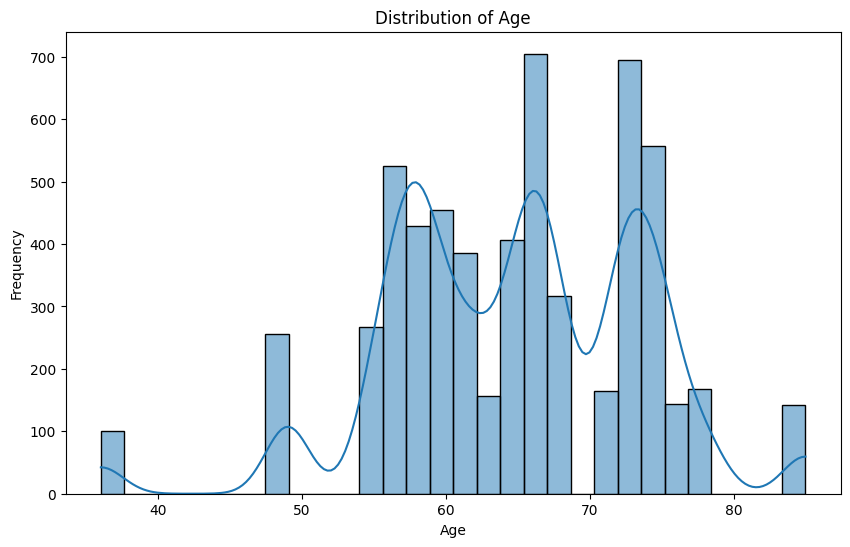

In [ ]:
# Exploratory Data Analysis
import seaborn as sns

# Shows the distribution of ages in the dataset,
# with bins representing age ranges
# and the KDE plot indicating the smoothed density of age values.
plt.figure(figsize=(10, 6))
sns.histplot(data=ptData, x='age', bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

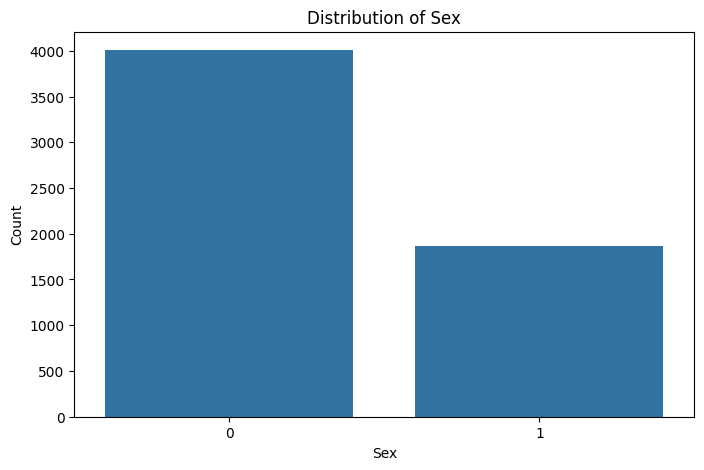

In [ ]:
# Displays the count of male and female participants in the dataset, providing an overview of the sex distribution.
plt.figure(figsize=(8, 5))
sns.countplot(data=ptData, x='sex')
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

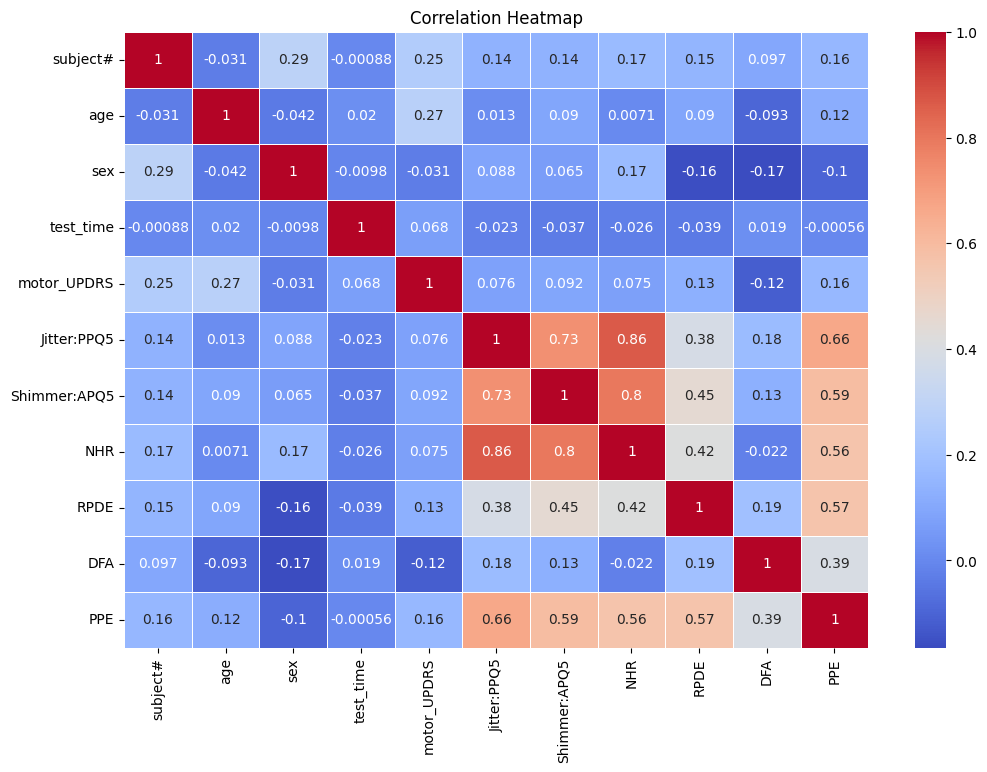

In [ ]:
# Visualizes the correlation between variables in the dataset using a color-coded heatmap,
# where brighter colors indicate stronger correlations.
correlation_matrix = ptData.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


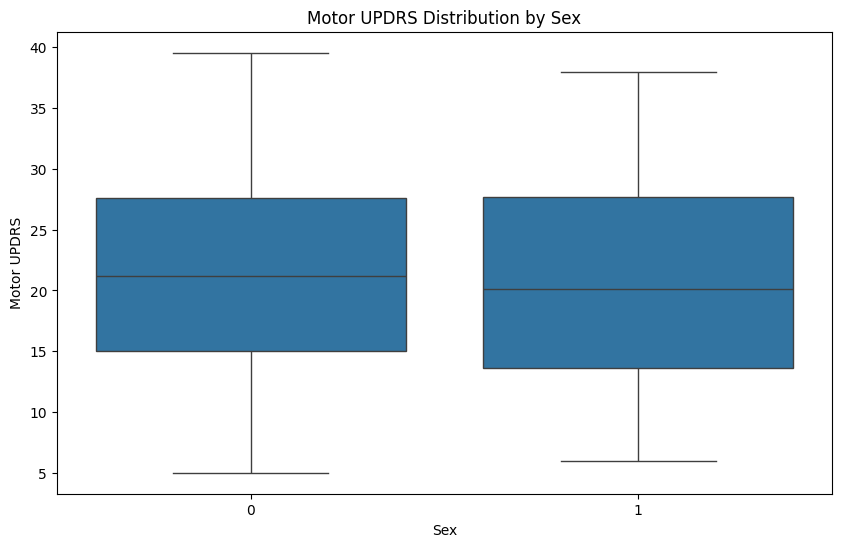

In [ ]:
# Illustrates the distribution of motor UPDRS scores grouped by sex,
# showing potential differences or patterns in UPDRS scores between males and females.
plt.figure(figsize=(10, 6))
sns.boxplot(data=ptData, x='sex', y='motor_UPDRS')
plt.title('Motor UPDRS Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Motor UPDRS')
plt.show()

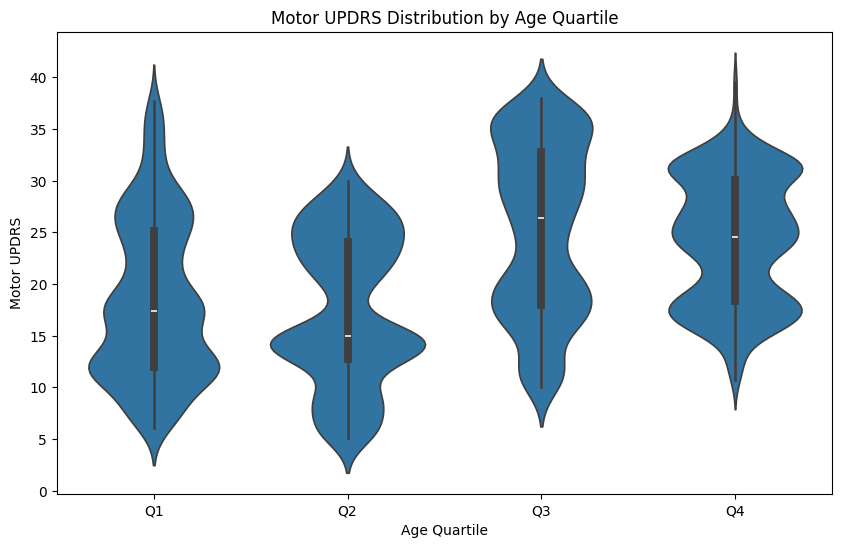

In [ ]:
# Presents the distribution of motor UPDRS scores across age quartiles,
# highlighting any variations or trends in UPDRS scores based on age groups.

# Creating age quartiles
ptData['age_quartile'] = pd.qcut(ptData['age'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

plt.figure(figsize=(10, 6))
sns.violinplot(data=ptData, x='age_quartile', y='motor_UPDRS')
plt.title('Motor UPDRS Distribution by Age Quartile')
plt.xlabel('Age Quartile')
plt.ylabel('Motor UPDRS')
plt.show()

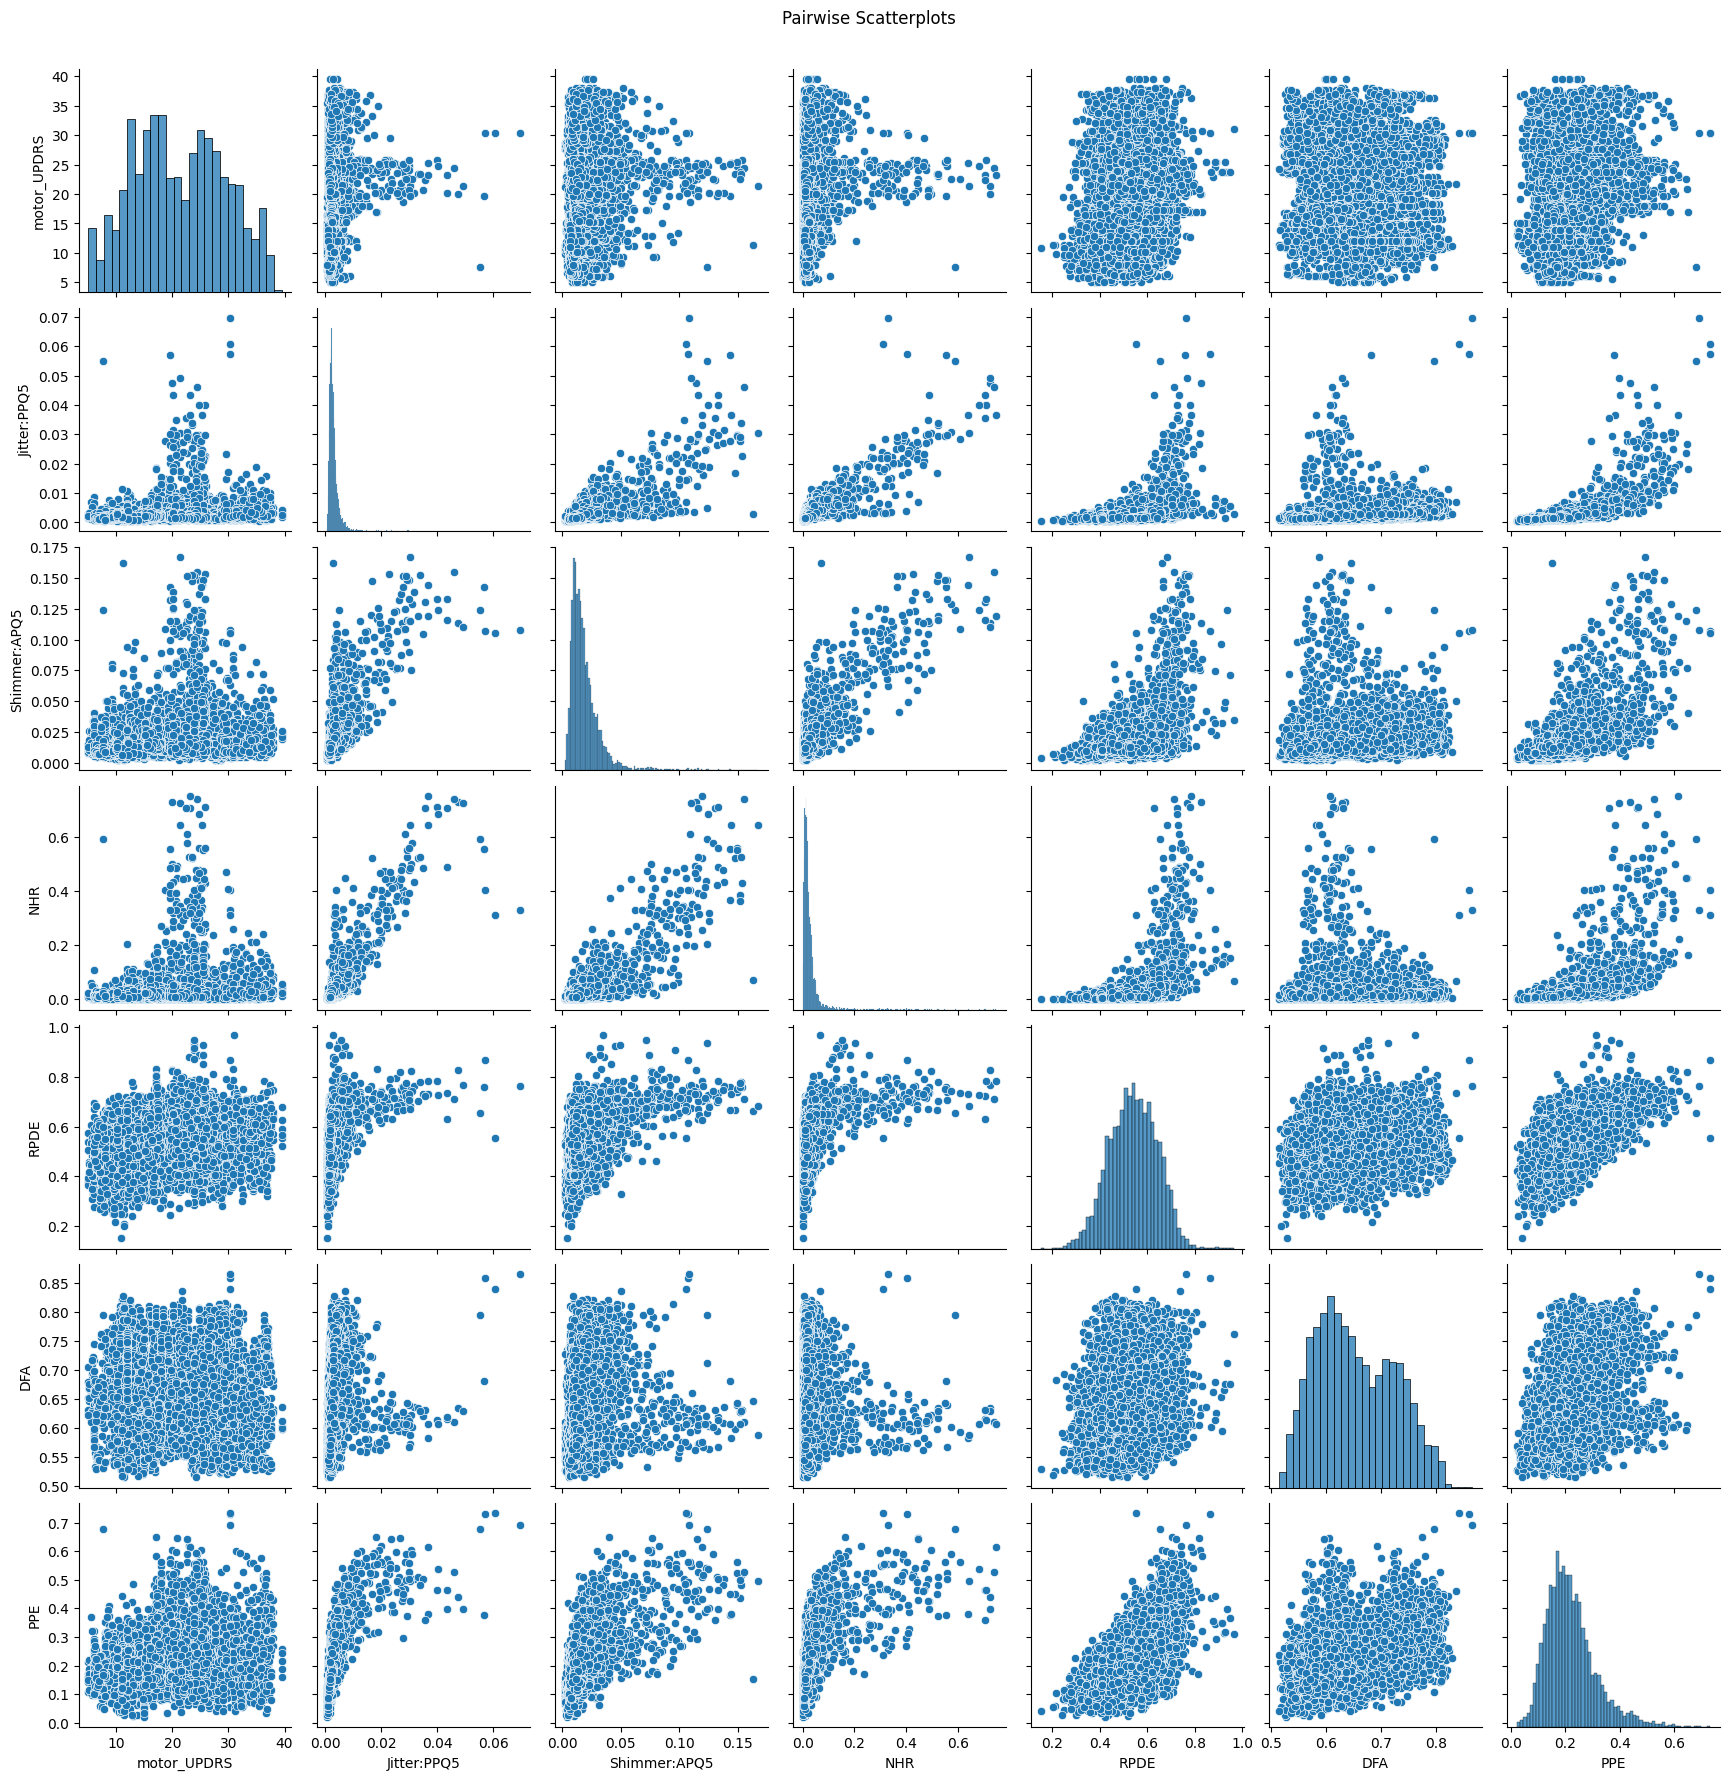

In [ ]:
# Displays scatterplots for each pair of variables
# ('motor_UPDRS', 'Jitter:PPQ5', 'Shimmer:APQ5', 'NHR', 'RPDE', 'DFA', 'PPE') to visualize their relationships and potential patterns.
sns.pairplot(data=ptData[['motor_UPDRS', 'Jitter:PPQ5', 'Shimmer:APQ5', 'NHR', 'RPDE', 'DFA', 'PPE']])
plt.suptitle('Pairwise Scatterplots', y=1.02)
plt.show()

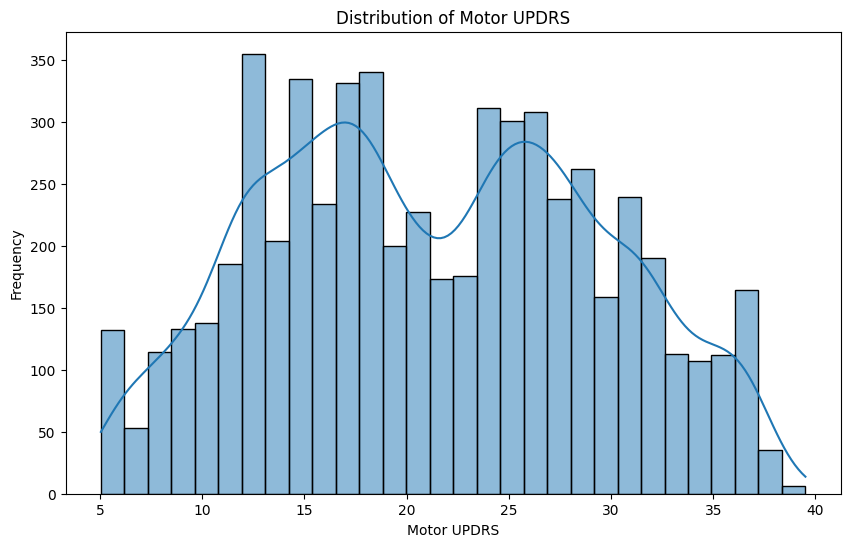

In [ ]:
# Shows the distribution of motor UPDRS scores in the dataset,
# providing insights into the range and frequency of UPDRS scores among participants.
plt.figure(figsize=(10, 6))
sns.histplot(data=ptData, x='motor_UPDRS', bins=30, kde=True)
plt.title('Distribution of Motor UPDRS')
plt.xlabel('Motor UPDRS')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Split data
X = ptData[['age', 'sex', 'test_time', 'Jitter:PPQ5', 'Shimmer:APQ5', 'NHR', 'RPDE', 'DFA', 'PPE']]

# motor_UPDRS scores above 20 are considered severe
# Define a function to convert motor_UPDRS to booleans
def severity(x):
    if x > 20:
        return 1
    else:
        return 0

y = ptData['motor_UPDRS'].apply(severity)

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# Scale/transform numeric columns using StandardScaler
from sklearn.preprocessing import StandardScaler
num_cols = ['age', 'test_time', 'Jitter:PPQ5', 'Shimmer:APQ5', 'NHR', 'RPDE', 'DFA', 'PPE']
scaler = StandardScaler()
scaler.fit(X_train[num_cols]) # Fit training data
X_train.loc[:, num_cols] = scaler.transform(X_train[num_cols]) # Transform training data
X_test.loc[:, num_cols] = scaler.transform(X_test[num_cols]) # Transform testing data


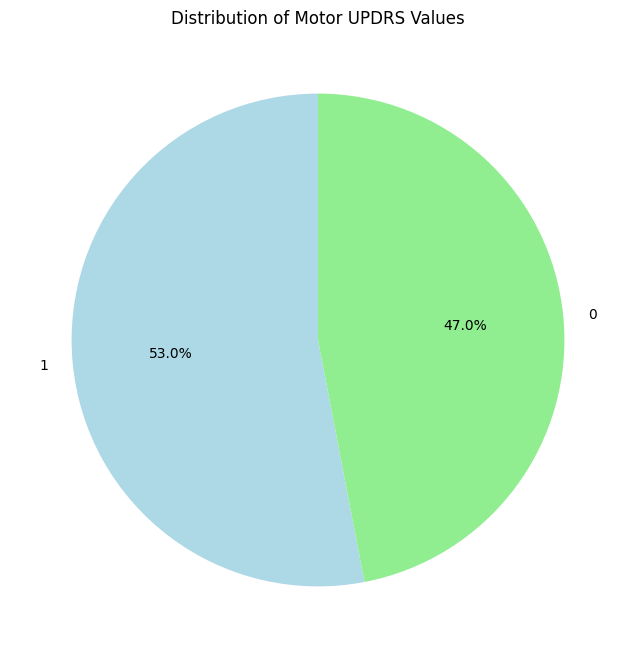

In [ ]:
# Get the count of each value in 'motor_UPDRS'
motor_updrs_counts = y.value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(motor_updrs_counts, labels=motor_updrs_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Distribution of Motor UPDRS Values')
plt.show()


In [ ]:
# Fit Logistic Model using Statsmodel
print('Statsmodel Logistic Regression:')
import statsmodels.api as sm
X_train_int = sm.add_constant(X_train)
logreg = sm.GLM(y_train, X_train_int, family = sm.families.Binomial() ).fit()
print(logreg.summary())

"""
Statsmodel Logistic Regression:
                    Generalized Linear Model Regression Results
==============================================================================
Dep. Variable:            motor_UPDRS   No. Observations:                 4112
Model:                            GLM   Df Residuals:                     4102
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2666.5
Date:                                   Deviance:                       5332.9
Time:                                   Pearson chi2:                 4.12e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08166
Covariance Type:            nonrobust
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2222      0.040      5.506      0.000       0.143       0.301
age              0.2092      0.034      6.140      0.000       0.142       0.276
sex             -0.2386      0.074     -3.209      0.001      -0.384      -0.093
test_time        0.0612      0.033      1.874      0.061      -0.003       0.125
Jitter:PPQ5     -0.1208      0.084     -1.438      0.150      -0.286       0.044
Shimmer:APQ5     0.1691      0.062      2.726      0.006       0.048       0.291
NHR              0.0669      0.097      0.687      0.492      -0.124       0.258
RPDE             0.0981      0.042      2.337      0.019       0.016       0.180
DFA             -0.4531      0.041    -11.114      0.000      -0.533      -0.373
PPE              0.3235      0.056      5.744      0.000       0.213       0.434
================================================================================
"""
# Jitter & NHR are statistically insignificant

# Coefficient interpretation
# Age           (0.2092) :  The likelihood of a parkinsons patient having a severe case increases 23.27% each year as they get older.
# Sex           (-0.2386):  Females are 21.23% less likely to develop severe cases of parkinsons
# Shimmer:APQ5  (0.1691) :  The likelihood of a parkinsons patient having a severe case increases by 0.1842% per every 0.001 units of APQ5 Shimmer
# RPDE          (0.0981) :  The likelihood of a parkingsons patient having a severse case increases by 1.031% per every 0.01 units of the RPDE dynamical complexity measure
# DFA           (-0.4531):  The likelihood of a parkinsons patient having a severe case decreases by 3.645% per every 0.1 units of the Signal fractal scaling exponent scale
# PPE           (0.3235) :  The likelihood of a parkisons patient having a severe case decreases increases by 3.82% per every 0.1 units of fundamental frequency variation
print("\n")


Statsmodel Logistic Regression:
                 Generalized Linear Model Regression Results                  
Dep. Variable:            motor_UPDRS   No. Observations:                 4112
Model:                            GLM   Df Residuals:                     4102
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2666.5
Date:                Wed, 22 May 2024   Deviance:                       5332.9
Time:                        16:13:09   Pearson chi2:                 4.12e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08166
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           

In [ ]:
# Fit Logistic Model using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
lr = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 10000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print('sklearn Logistic Regression:')
confmat = confusion_matrix(y_test, y_pred, labels = [1,0])
TP = confmat[0,0]
FN = confmat[0,1]
FP = confmat[1,0]
TN = confmat[1,1]

Accuracy = (TP + TN) / sum(sum(confmat)) #Accuracy
TPR = TP / (TP + FN) # True Positive Rate, Sensitivity, Recall
FPR = FP / (FP + TN) # False Positive Rate
TNR = TN / (TN + FP) # True Negative Rate, Specificity
FNR = FN / (FN + TP) # False Negative Rate
Precision = TP / (TP + FP) # Precision
Youden = TPR + TNR - 1
FScore = ( 2 * Precision * TPR ) / ( Precision + TPR )

# We will create a reference table to compare the various upcoming models.
Acc_Comp = pd.DataFrame()
Acc_Comp['Model'] = ['sklearn LogReg']
Acc_Comp['Accuracy'] = [Accuracy]
Acc_Comp['F-score'] = [FScore]

print('Confusion Matrix \n', confmat)
print("False Positive Rate = %f" %FPR)
print("False Negative Rate = %f" %FNR)
print("True Positive Rate = %f" %TPR)
print("True Negative Rate = %f" %TNR)
print("Accuracy = %f" %Accuracy)
print("Precision = %f" %Precision)
print("Youden Index = %f" %Youden)
print("F-score = %f" %FScore)
print("\n")

sklearn Logistic Regression:
Confusion Matrix 
 [[623 303]
 [413 424]]
False Positive Rate = 0.493429
False Negative Rate = 0.327214
True Positive Rate = 0.672786
True Negative Rate = 0.506571
Accuracy = 0.593874
Precision = 0.601351
Youden Index = 0.179357
F-score = 0.635066




In [ ]:
# Find the best threshold value a based on maximizing Youden Index and F-score

# Set up threshold criteria
thresholds = np.linspace(0,1,52)
thresholds= np.delete(thresholds,[0,51])

# Set up matrices to store hyperparameter scores
youden_all = np.zeros(len(thresholds))
fscore_all = np.zeros(len(thresholds))

# Set up 5-Fold CV model selection
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_index, valid_index in kfold.split(X_train):
    X_training, y_training=X_train.iloc[train_index], y_train.iloc[train_index]
    X_valid, y_valid=X_train.iloc[valid_index], y_train.iloc[valid_index]

    # Scale/transform data using StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_training)
    X_training = pd.DataFrame(scaler.transform(X_training))
    X_valid = pd.DataFrame(scaler.transform(X_valid))
    X_training.columns = X.columns.values
    X_valid.columns = X.columns.values

    # Fit model
    lr=LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 10000)
    lr.fit(X_training, y_training)
    pred_prob=lr.predict_proba(X_valid)

    for i,value in enumerate(thresholds):
        #For each value of threshold
        yhat=np.where(pred_prob[:,1] > value, 1, 0)
        confmat=confusion_matrix(y_valid, yhat, labels=[1,0])
        TP = confmat[0,0]
        FN = confmat[0,1]
        FP = confmat[1,0]
        TN = confmat[1,1]

        Acc = (TP + TN) / sum(sum(confmat))
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        TNR = TN / (TN + FP)
        FNR = FN / (FN + TP)
        Precision = TP / (TP + FP)
        Youden = TPR + TNR - 1
        FScore = ( 2 * Precision * TPR ) / ( Precision + TPR )
        youden_all[i]= Youden
        fscore_all[i]= FScore


# Identify best indices and optimal threshold values
bestYouden = thresholds[np.argmax(youden_all)]
print("Youden is optimized when a = %f" %bestYouden)    # a = 0.45098

# We have instances where Precision & TPR = 0. We will remove nan values from fscore array to avoid errors
fscore_all = fscore_all[~np.isnan(fscore_all)]
bestFscore = thresholds[np.argmax(fscore_all)]
print("F-score is optimized when a = %f" %bestFscore)    # a = 0.352941
print("\n")

Youden is optimized when a = 0.450980
F-score is optimized when a = 0.352941




In [ ]:
# Youden Threshold Predication
print("Youden Threshold Prediction:")

# Fit model
lr.fit(X_train,y_train)
yhat = np.where(lr.predict_proba(X_test)[:,1] > bestYouden,1,0)
confmat = confusion_matrix(y_test,yhat,labels=[1,0])

#Calculate metrics:
TP = confmat[0,0]
FN = confmat[0,1]
FP = confmat[1,0]
TN = confmat[1,1]

Acc = (TP + TN) / sum(sum(confmat))
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)
FNR = FN / (FN + TP)
Precision = TP / (TP + FP)
Youden = TPR + TNR - 1
FScore = ( 2 * Precision * TPR ) / ( Precision + TPR )

# Update the reference table
YoudenRef = {'Model':'Youden Threshold','Accuracy':Acc, 'F-score': FScore}
Acc_Comp = Acc_Comp._append(YoudenRef, ignore_index = True)

print(confmat)
print("False Positive Rate = %f" %FPR)
print("False Negative Rate = %f" %FNR)
print("True Positive Rate = %f" %TPR)
print("True Negative Rate = %f" %TNR)
print("Accuracy = %f" %Acc)
print("Precision = %f" %Precision)
print("Youden Index = %f" %Youden)
print("F-score = %f" %FScore)
print("\n")

Youden Threshold Prediction:
[[737 189]
 [502 335]]
False Positive Rate = 0.599761
False Negative Rate = 0.204104
True Positive Rate = 0.795896
True Negative Rate = 0.400239
Accuracy = 0.608054
Precision = 0.594835
Youden Index = 0.196135
F-score = 0.680831




In [ ]:
# F Score Threshold Prediction
print("F-score Threshold Prediction:")

# Fit model
lr.fit(X_train,y_train)
yhat = np.where(lr.predict_proba(X_test)[:,1] > bestFscore, 1, 0)
confmat = confusion_matrix(y_test, yhat, labels=[1,0])

#Calculate metrics:
TP = confmat[0,0]
FN = confmat[0,1]
FP = confmat[1,0]
TN = confmat[1,1]

Acc = (TP + TN) / sum(sum(confmat))
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)
FNR = FN / (FN + TP)
Precision = TP / (TP + FP)
Youden = TPR + TNR - 1
FScore = ( 2 * Precision * TPR ) / ( Precision + TPR )

FscoreRef = {'Model':'F-score Threshold','Accuracy':Acc, 'F-score': FScore}
Acc_Comp = Acc_Comp._append(FscoreRef, ignore_index = True)

print(confmat)
print("False Positive Rate = %f" %FPR)
print("False Negative Rate = %f" %FNR)
print("True Positive Rate = %f" %TPR)
print("True Negative Rate = %f" %TNR)
print("Accuracy = %f" %Acc)
print("Precision = %f" %Precision)
print("Youden Index = %f" %Youden)
print("F-score = %f" %FScore)
print("\n")

F-score Threshold Prediction:
[[882  44]
 [674 163]]
False Positive Rate = 0.805257
False Negative Rate = 0.047516
True Positive Rate = 0.952484
True Negative Rate = 0.194743
Accuracy = 0.592740
Precision = 0.566838
Youden Index = 0.147227
F-score = 0.710717




In [ ]:
# 5-Fold LassoCV Penalty
print("5-Fold LassoCV:")

# Set up candidate hyperparameters
lambdas = np.logspace(-10,10,30)
Acc_list = np.zeros(len(lambdas))

# Set up 5-Fold CV Model selection
for train_index, valid_index in kfold.split(X_train):
    X_training, y_training=X_train.iloc[train_index], y_train.iloc[train_index]
    X_valid, y_valid=X_train.iloc[valid_index], y_train.iloc[valid_index]

    for i, value in enumerate(lambdas):
        lr = LogisticRegression(C=value,penalty = 'l1', solver = 'liblinear', max_iter = 10000)
        lr.fit(X_training, y_training)
        yhat=np.where(lr.predict_proba(X_valid)[:,1] > bestFscore,1,0)
        confmat=confusion_matrix(y_valid,yhat,labels=[1,0])
        TP = confmat[0,0]
        FN = confmat[0,1]
        FP = confmat[1,0]
        TN = confmat[1,1]
        #Calculate accuracy
        Acc = (TP + TN) / sum(sum(confmat))
        Acc_list[i] = Acc_list[i] + Acc

Acc_list = Acc_list[~np.isnan(Acc_list)]
best_lambda = lambdas[np.argmax(Acc_list)]

#Fit lasso regression model using optimal value for lambda
lr = LogisticRegression(C=best_lambda,penalty = 'l1', solver = 'liblinear', max_iter = 10000)
lr.fit(X_train, y_train)
pred_test=lr.predict_proba(X_test)
yhat=np.where(pred_test[:,1] > bestFscore,1,0)
confmat=confusion_matrix(y_test,yhat,labels=[1,0])
TP = confmat[0,0]
FN = confmat[0,1]
FP = confmat[1,0]
TN = confmat[1,1]

Acc = (TP + TN) / sum(sum(confmat))
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)
FNR = FN / (FN + TP)
Precision = TP / (TP + FP)
Youden = TPR + TNR - 1
FScore = ( 2 * Precision * TPR ) / ( Precision + TPR )

LassoRef = {'Model':'5-Fold LassoCV','Accuracy': Acc, 'F-score': FScore}
Acc_Comp = Acc_Comp._append(LassoRef, ignore_index = True)

print(confmat)
print("False Positive Rate = %f" %FPR)
print("False Negative Rate = %f" %FNR)
print("True Positive Rate = %f" %TPR)
print("True Negative Rate = %f" %TNR)
print("Accuracy = %f" %Acc)
print("Precision = %f" %Precision)
print("Youden Index = %f" %Youden)
print("F-score = %f" %FScore)

# Evaluate statistically insignificant variables
df = pd.DataFrame(zip(X_train.columns.values, lr.coef_.tolist()[0]))
df.columns = ['feature', 'coef']
sorted = df.sort_values(by=['coef'], axis = 0, ascending = False)
print("Most important features: ")
print(sorted)

"""
5-Fold LassoCV:
[[888  38]
 [678 159]]
False Positive Rate = 0.810036
False Negative Rate = 0.041037
True Positive Rate = 0.958963
True Negative Rate = 0.189964
Accuracy = 0.593874
Precision = 0.567050
Youden Index = 0.148927
F-score = 0.712681
Most important features:
        feature      coef
4  Shimmer:APQ5  5.030792
8           PPE  3.188990
6          RPDE  1.161705
5           NHR  0.438561
0           age  0.025352
2     test_time  0.001150
3   Jitter:PPQ5  0.000000
1           sex -0.230423
7           DFA -6.252853
"""
print("\n")

5-Fold LassoCV:
[[888  38]
 [678 159]]
False Positive Rate = 0.810036
False Negative Rate = 0.041037
True Positive Rate = 0.958963
True Negative Rate = 0.189964
Accuracy = 0.593874
Precision = 0.567050
Youden Index = 0.148927
F-score = 0.712681
Most important features: 
        feature      coef
4  Shimmer:APQ5  5.030792
8           PPE  3.188990
6          RPDE  1.161705
5           NHR  0.438561
0           age  0.025352
2     test_time  0.001150
3   Jitter:PPQ5  0.000000
1           sex -0.230423
7           DFA -6.252853




In [ ]:
# 5-Fold CV Decision Tree (tuning max_depth, max_leaf_nodes and criterion)
print("5-Fold CV Decision Tree:")
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 1)

grid = {'max_depth': np.arange(2,50,2),
        'max_leaf_nodes': [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
        'criterion': ['gini', 'entropy']}

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score

dt = GridSearchCV(DecisionTreeClassifier(random_state = 1000, min_samples_leaf = 10), grid, cv = 5, scoring = 'f1', n_jobs = -1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
confmat=confusion_matrix(y_test,yhat,labels=[1,0])
TP = confmat[0,0]
FN = confmat[0,1]
FP = confmat[1,0]
TN = confmat[1,1]

Acc = (TP + TN) / sum(sum(confmat))
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)
FNR = FN / (FN + TP)
Precision = TP / (TP + FP)
Youden = TPR + TNR - 1
FScore = ( 2 * Precision * TPR ) / ( Precision + TPR )

print('Best Hyperparameters:', dt.best_params_)
print('F-score:', f1_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred, labels = [1,0]))
print('Accuracy:', accuracy_score(y_test, y_pred))

DTRef = {'Model':'Decision Tree','Accuracy':accuracy_score(y_test, y_pred), 'F-score': f1_score(y_test, y_pred)}
Acc_Comp = Acc_Comp._append(DTRef, ignore_index = True)

# Refit the model to get important features
best_dt = DecisionTreeClassifier(max_depth = dt.best_params_['max_depth'],
                             max_leaf_nodes = dt.best_params_['max_leaf_nodes'],
                             criterion = dt.best_params_['criterion'],
                             min_samples_leaf = 10, random_state = 1000)
best_dt.fit(X_train, y_train)
importance = pd.DataFrame({'feature':X.columns.values, 'DT':best_dt.feature_importances_})
print('Features ranked by importance: ')
print(importance.sort_values(by = ['DT'], ascending = False))

"""
5-Fold CV Decision Tree:
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 16, 'max_leaf_nodes': 64}
F-score: 0.9624866023579849
Confusion Matrix:
 [[898  28]
 [ 42 795]]
Accuracy: 0.9602949517867272
Features ranked by importance:
        feature        DT
0           age  0.676082
2     test_time  0.110670
1           sex  0.081139
7           DFA  0.050912
6          RPDE  0.045658
4  Shimmer:APQ5  0.027125
8           PPE  0.004482
3   Jitter:PPQ5  0.003933
5           NHR  0.000000
"""
print("\n")

5-Fold CV Decision Tree:
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 16, 'max_leaf_nodes': 64}
F-score: 0.9624866023579849
Confusion Matrix:
 [[898  28]
 [ 42 795]]
Accuracy: 0.9602949517867272
Features ranked by importance: 
        feature        DT
0           age  0.676082
2     test_time  0.110670
1           sex  0.081139
7           DFA  0.050912
6          RPDE  0.045658
4  Shimmer:APQ5  0.027125
8           PPE  0.004482
3   Jitter:PPQ5  0.003933
5           NHR  0.000000




In [ ]:
# Random Forest Classifier (5-Fold CV tuning n_estimators, max_features, and min_samples_leaf)
print("Random Forest Classifier:")

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import time

# RandomSearchCV
start = time.perf_counter()
rs_grid = {'n_estimators': np.arange(100, 1000, 100),
        'max_features': np.arange(1, 10, 1),
        'min_samples_leaf': np.arange(2, 10, 1)}

rf = RandomForestClassifier()

test_rs = RandomizedSearchCV(estimator = rf, param_distributions = rs_grid, cv=5)
rs = test_rs.fit(X_train, y_train)

end = time.perf_counter()
print("Random Search Time elapsed: " + str(end-start))
print("Random Search best parameters: ")
print(test_rs.best_params_)
print("Random Seach score: %f" %rs.best_score_)

# GridSearchCV
start = time.perf_counter()
gs_grid = {'n_estimators': np.arange(100, 800, 100),
           'max_features':  np.arange(3, 8, 1),
           'min_samples_leaf':np.arange(2, 5, 1)}

test_gs = GridSearchCV(estimator = rf, param_grid = gs_grid, cv=5)
gs = test_gs.fit(X_train, y_train)

end = time.perf_counter()
print("\nGrid Search Time elapsed: " + str(end-start))
print("Grid Search best parameters:")
print(gs.best_params_)
print("Grid Search score: %f" %gs.best_score_)

best_rf =  RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'],
                                      max_features = gs.best_params_['max_features'],
                                      min_samples_leaf = gs.best_params_['min_samples_leaf'],
                                      random_state = 1000)
best_rf.fit(X_train, y_train)
yhat = gs.predict(X_test)

RFRef = {'Model':'Random Forest','Accuracy':accuracy_score(y_test, yhat), 'F-score': f1_score(y_test, yhat)}
Acc_Comp = Acc_Comp._append(RFRef, ignore_index = True)

print('\nBest Hyperparameters:', gs.best_params_)
print('F-score:', f1_score(y_test, yhat))
print('Confusion Matrix:\n', confusion_matrix(y_test, yhat, labels = [1,0]))
print('Accuracy:', accuracy_score(y_test, yhat))
importance['RF'] = best_rf.feature_importances_
print('Features ranked by importance: ')
print(importance.sort_values(by = ['RF'], ascending = False))
"""
Random Forest Classifier:
Random Search Time elapsed: 340.07709272
Random Search best parameters:
{'n_estimators': 500, 'min_samples_leaf': 2, 'max_features': 8}
Random Seach score: 0.984678

Grid Search Time elapsed: 2696.379932115
Grid Search best parameters:
{'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 700}
Grid Search score: 0.985894

Best Hyperparameters: {'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 700}
F-score: 0.9833064081852451
Confusion Matrix:
 [[913  13]
 [ 18 819]]
Accuracy: 0.9824163357912649
Features ranked by importance:
        feature        DT        RF
0           age  0.676082  0.563198
7           DFA  0.050912  0.093661
2     test_time  0.110670  0.087358
6          RPDE  0.045658  0.078496
1           sex  0.081139  0.058976
4  Shimmer:APQ5  0.027125  0.053995
3   Jitter:PPQ5  0.003933  0.026663
5           NHR  0.000000  0.018979
8           PPE  0.004482  0.018673
"""
print("\n")

Random Forest Classifier:
Random Search Time elapsed: 340.07709272
Random Search best parameters: 
{'n_estimators': 500, 'min_samples_leaf': 2, 'max_features': 8}
Random Seach score: 0.984678

Grid Search Time elapsed: 2696.379932115
Grid Search best parameters:
{'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 700}
Grid Search score: 0.985894

Best Hyperparameters: {'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 700}
F-score: 0.9833064081852451
Confusion Matrix:
 [[913  13]
 [ 18 819]]
Accuracy: 0.9824163357912649
Features ranked by importance: 
        feature        DT        RF
0           age  0.676082  0.563198
7           DFA  0.050912  0.093661
2     test_time  0.110670  0.087358
6          RPDE  0.045658  0.078496
1           sex  0.081139  0.058976
4  Shimmer:APQ5  0.027125  0.053995
3   Jitter:PPQ5  0.003933  0.026663
5           NHR  0.000000  0.018979
8           PPE  0.004482  0.018673




In [ ]:
# Gradient Boosting Tree (tuning n_estimators, max_features, and learning_rate)
print("Gradient Boosting Tree:")
from sklearn.ensemble import GradientBoostingClassifier

start = time.perf_counter()
gb_grid = {'n_estimators': [300,400,500,600,700],
           'learning_rate': [0.1, 0.5, 0.1],
           'max_depth': [2,3,4]}

gb = GridSearchCV(GradientBoostingClassifier(min_samples_leaf = 5, random_state = 1),
                    param_grid = gb_grid, cv = 5, n_jobs = -1, scoring = 'f1')

gb.fit(X_train, y_train)
yhat = gb.predict(X_test)
end = time.perf_counter()
print("Grid Search Time elapsed: " + str(end-start))

print('Best Hyperparameters:', gb.best_params_)
print('F-score on Testing Set:', f1_score(y_test, yhat))
print('Confusion Matrix:\n', confusion_matrix(y_test, yhat, labels = [1,0]))
print('Accuracy:', accuracy_score(y_test, yhat))

GBRef = {'Model':'Gradient Boosting','Accuracy':accuracy_score(y_test, yhat), 'F-score': f1_score(y_test, yhat)}
Acc_Comp = Acc_Comp._append(GBRef, ignore_index = True)

# Refit the model to get important features
best_gb = GradientBoostingClassifier(n_estimators = gb.best_params_['n_estimators'],
                                          learning_rate = gb.best_params_['learning_rate'],
                                          max_depth = gb.best_params_['max_depth'],
                                          min_samples_leaf = 5, random_state = 1)
best_gb.fit(X_train, y_train)
importance['GB'] = best_gb.feature_importances_
print('Features ranked by importance: ')
print(importance.sort_values(by = ['GB'], ascending = False))

"""
Gradient Boosting Tree:
Grid Search Time elapsed: 468.6657329589998
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
F-score on Testing Set: 0.9854290339989207
Confusion Matrix:
 [[913  13]
 [ 14 823]]
Accuracy: 0.9846851956891662
Features ranked by importance:
        feature        DT        RF        GB
0           age  0.676082  0.564053  0.632644
1           sex  0.081139  0.059208  0.112975
7           DFA  0.050912  0.094313  0.078907
2     test_time  0.110670  0.087416  0.068249
6          RPDE  0.045658  0.078170  0.061252
4  Shimmer:APQ5  0.027125  0.053538  0.023501
3   Jitter:PPQ5  0.003933  0.026273  0.010239
8           PPE  0.004482  0.018201  0.008807
5           NHR  0.000000  0.018828  0.003425
"""
print("\n")


Gradient Boosting Tree:
Grid Search Time elapsed: 486.805536155
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
F-score on Testing Set: 0.9854290339989207
Confusion Matrix:
 [[913  13]
 [ 14 823]]
Accuracy: 0.9846851956891662
Features ranked by importance: 
        feature        DT        RF        GB
0           age  0.676082  0.563198  0.632644
1           sex  0.081139  0.058976  0.112975
7           DFA  0.050912  0.093661  0.078907
2     test_time  0.110670  0.087358  0.068249
6          RPDE  0.045658  0.078496  0.061252
4  Shimmer:APQ5  0.027125  0.053995  0.023501
3   Jitter:PPQ5  0.003933  0.026663  0.010239
8           PPE  0.004482  0.018673  0.008807
5           NHR  0.000000  0.018979  0.003425




In [ ]:
# Cumulative Model Comparison
print(Acc_Comp)
"""
               Model  Accuracy   F-score
0     sklearn LogReg  0.593874  0.635066
1   Youden Threshold  0.608054  0.680831
2  F-score Threshold  0.592740  0.710717
3     5-Fold LassoCV  0.612025  0.687956
4      Decision Tree  0.960295  0.962487
5      Random Forest  0.981849  0.982759
6  Gradient Boosting  0.984685  0.985429
"""
print("\n\t\t(｡◕‿‿◕｡)")

               Model  Accuracy   F-score
0     sklearn LogReg  0.593874  0.635066
1   Youden Threshold  0.608054  0.680831
2  F-score Threshold  0.592740  0.710717
3     5-Fold LassoCV  0.593874  0.712681
4      Decision Tree  0.960295  0.962487
5      Random Forest  0.982416  0.983306
6  Gradient Boosting  0.984685  0.985429

		(｡◕‿‿◕｡)
